 ## Name-Etishree Sahu (DS/ML)
 ## Project-Shopper Spectrum

###Problem Statement-
In the competitive world of e-commerce, understanding customer behavior and offering tailored product recommendations is crucial. This project aims to:

Segment customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis and KMeans clustering.

Build a recommendation system to suggest similar products using item-item cosine similarity on transaction data.

###Github Link

https://github.com/EtishreeSahu/shopper-spectrum-app/tree/main

Streamlit App Link

https://shopper-spectrum-app-hqtme5uzbdcjeqnzrjz9lk.streamlit.app/

###Step 1A: Download & Load Dataset

In [1]:
# Install gdown first if not installed
!pip install gdown

# Use this to download the file directly from Google Drive
import gdown

# Your Google Drive shared link
url = "https://drive.google.com/uc?id=1rzRwxm_CJxcRzfoo9Ix37A2JTlMummY-"
output = "ecommerce_data.csv"  # or .xlsx depending on file format
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1rzRwxm_CJxcRzfoo9Ix37A2JTlMummY-
To: /content/ecommerce_data.csv
100%|██████████| 48.6M/48.6M [00:00<00:00, 102MB/s]


'ecommerce_data.csv'

### Step 1: Load and Explore the Dataset

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('ecommerce_data.csv', encoding='ISO-8859-1')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check data types and missing values
print("\nDataset info:")
print(df.info())

# Count missing values in each column
print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (541909, 8)

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column     

###Step 2: Data Cleaning



In [3]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with Quantity <= 0 or UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Confirm shape after cleaning
print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (397884, 8)


###Step 3: Exploratory Data Analysis (EDA)

###3.1: Transactions by Country

In [4]:
# Count of transactions by country (descending)
country_txn = df['Country'].value_counts().sort_values(ascending=False)

print("Top 10 countries by transaction count:")
print(country_txn.head(10))


Top 10 countries by transaction count:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64


###3.2: Top-Selling Products

In [5]:
# Top products by quantity sold
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)

print("Top 10 best-selling products:")
print(top_products.head(10))


Top 10 best-selling products:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
ASSORTED COLOUR BIRD ORNAMENT         35362
PACK OF 72 RETROSPOT CAKE CASES       33693
POPCORN HOLDER                        30931
RABBIT NIGHT LIGHT                    27202
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


###3.3: Purchase Trends Over Time

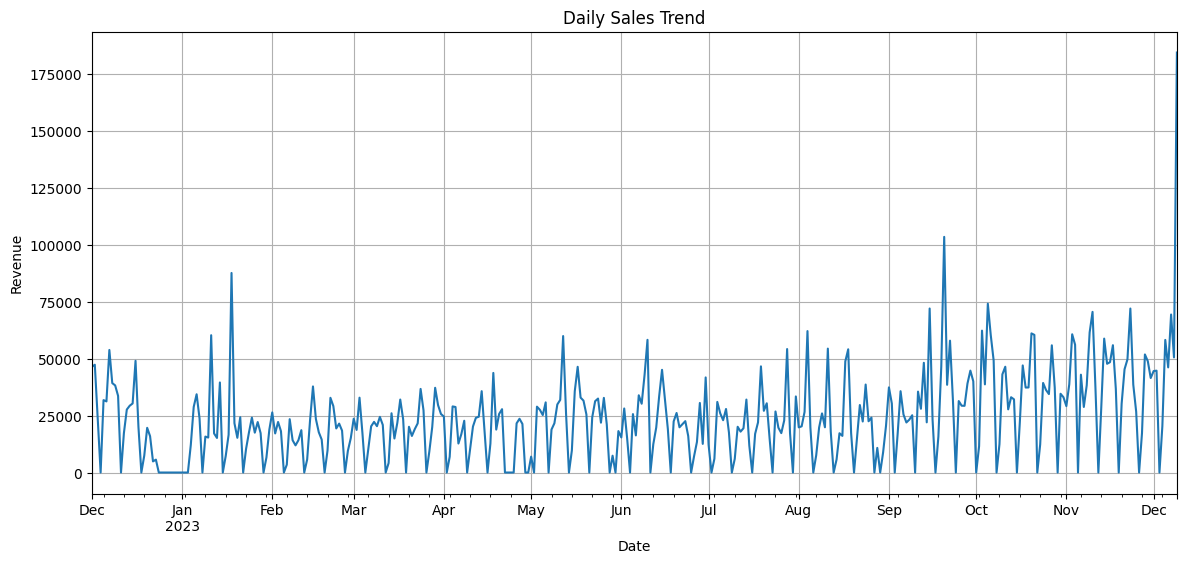

In [6]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by date and sum revenue
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
daily_sales = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


###3.4: Revenue Distribution per Customer

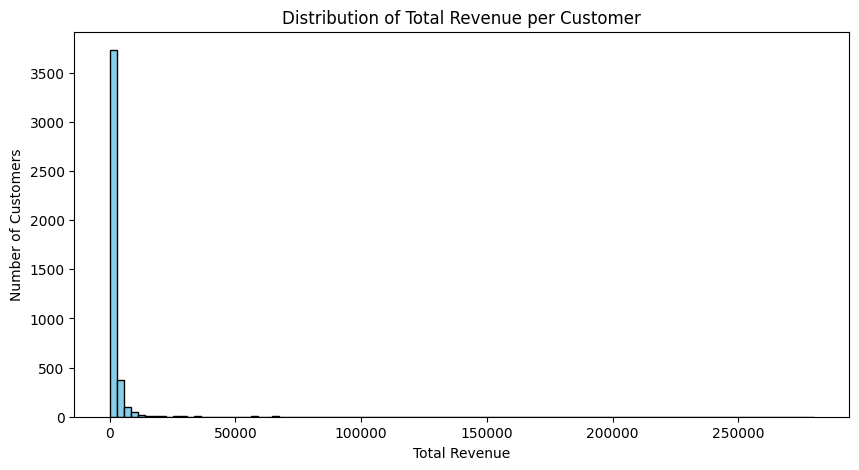

In [7]:
customer_revenue = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(10,5))
plt.hist(customer_revenue, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Revenue per Customer')
plt.xlabel('Total Revenue')
plt.ylabel('Number of Customers')
plt.show()

###Step 4: RFM Feature Engineering & Clustering
4.1: RFM Calculation
We calculate:

Recency = Days since last purchase (from dataset max date)

Frequency = Number of transactions per customer

Monetary = Total amount spent

In [8]:
import datetime as dt

# Reference date = one day after the last InvoiceDate
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display sample
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


###4.2: Scaling the RFM Features

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


###4.3: Elbow Method (to find optimal number of clusters)

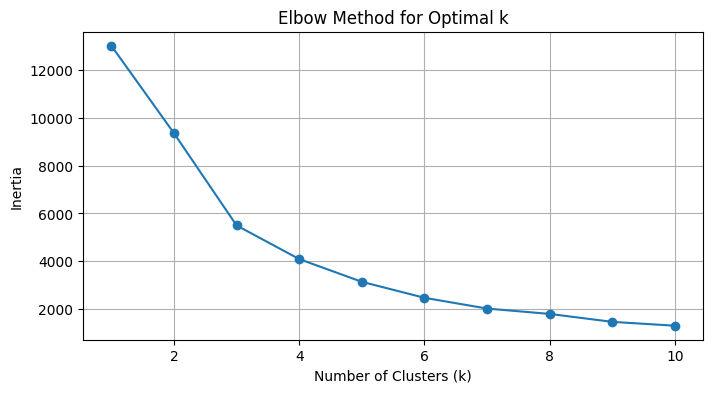

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(1,11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


###4.4: Apply KMeans Clustering

In [11]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View RFM with cluster labels
print(rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'}))


            Recency  Frequency       Monetary  CustomerCount
Cluster                                                     
0         43.702685   3.682711    1359.049284           3054
1        248.075914   1.552015     480.617480           1067
2          7.384615  82.538462  127338.313846             13
3         15.500000  22.333333   12709.090490            204


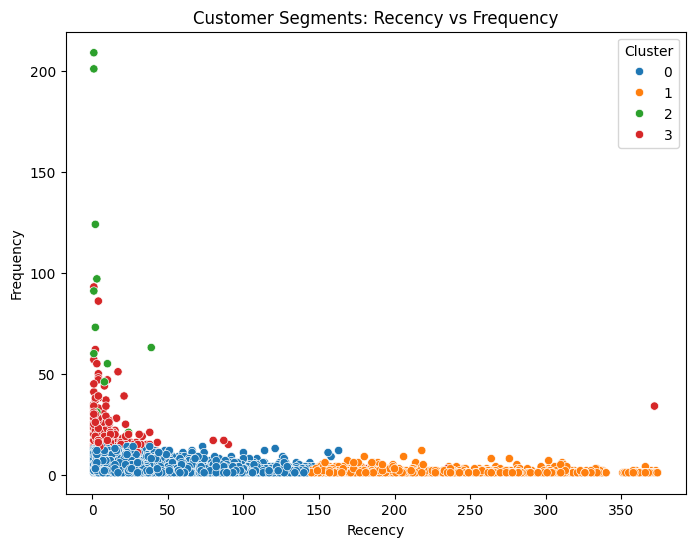

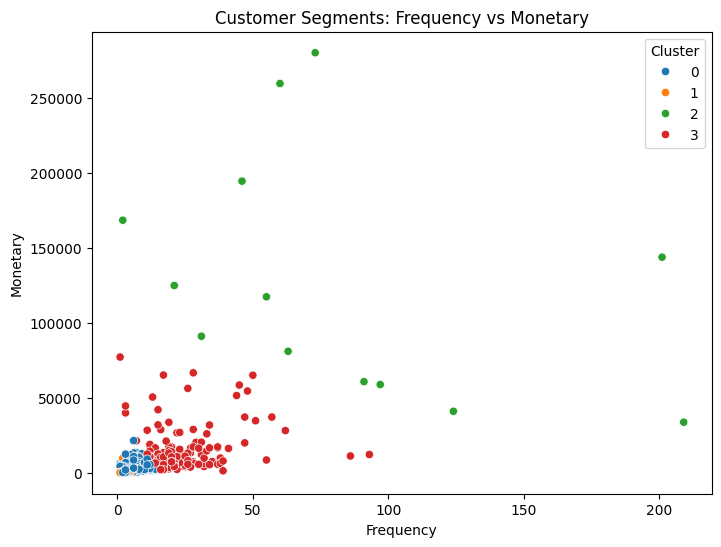

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already assigned cluster labels to `rfm`
# For example:
# kmeans = KMeans(n_clusters=4, random_state=42)
# rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 1. Plot Recency vs Frequency
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='tab10')
plt.title("Customer Segments: Recency vs Frequency")
plt.show()

# 2. Plot Monetary vs Frequency
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Segments: Frequency vs Monetary")
plt.show()

# 3. Optional: 3D plot if needed (Recency, Frequency, Monetary)


###4.5: Label Clusters (Optional but important for UI)

In [13]:
def assign_label(row):
    if row['Recency'] < 30 and row['Frequency'] > 10 and row['Monetary'] > 1000:
        return 'High-Value'
    elif row['Recency'] < 60 and row['Frequency'] > 5:
        return 'Regular'
    elif row['Recency'] > 120:
        return 'At-Risk'
    else:
        return 'Occasional'

rfm['Segment'] = rfm.apply(assign_label, axis=1)
print(rfm[['CustomerID', 'Cluster', 'Segment']].head())


   CustomerID  Cluster     Segment
0     12346.0        3     At-Risk
1     12347.0        0     Regular
2     12348.0        0  Occasional
3     12349.0        0  Occasional
4     12350.0        1     At-Risk


###Step 5: Product Recommendation System (Item-Based)
Goal:
Recommend 5 similar products based on product co-purchase patterns using cosine similarity.

###5.1: Create Item-User Matrix



In [14]:
# Create a pivot table with CustomerID as rows, StockCode as columns
item_user_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)


###5.2: Compute Cosine Similarity Between Items

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Transpose so that products are rows
product_similarity = cosine_similarity(item_user_matrix.T)

# Convert to DataFrame for easy lookup
similarity_df = pd.DataFrame(product_similarity,
                             index=item_user_matrix.columns,
                             columns=item_user_matrix.columns)


###5.3: Define Recommendation Function

In [16]:
def recommend_similar_products(product_code, n=5):
    if product_code not in similarity_df.columns:
        print("Product not found.")
        return []

    # Sort by similarity score (excluding the product itself)
    similar_products = similarity_df[product_code].sort_values(ascending=False).drop(product_code).head(n)

    return similar_products


###5.4: Example Usage

In [17]:
recommendations = recommend_similar_products('85123A', n=5)
print("Top 5 similar products:\n", recommendations)


Top 5 similar products:
 StockCode
21175    0.749651
21733    0.658732
82552    0.643868
82551    0.642480
23288    0.630982
Name: 85123A, dtype: float64


###Apply PCA for 2D Visualization

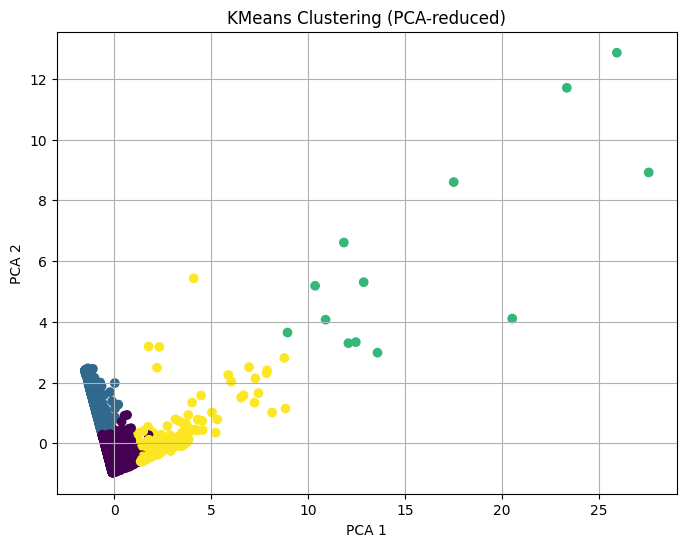

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('KMeans Clustering (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


###Try DBSCAN

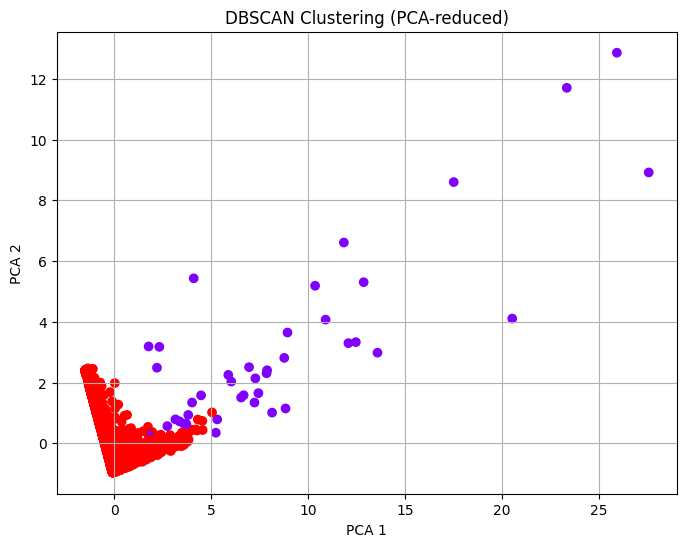

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=5)
db_labels = dbscan.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=db_labels, cmap='rainbow')
plt.title('DBSCAN Clustering (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


###Try Agglomerative Clustering

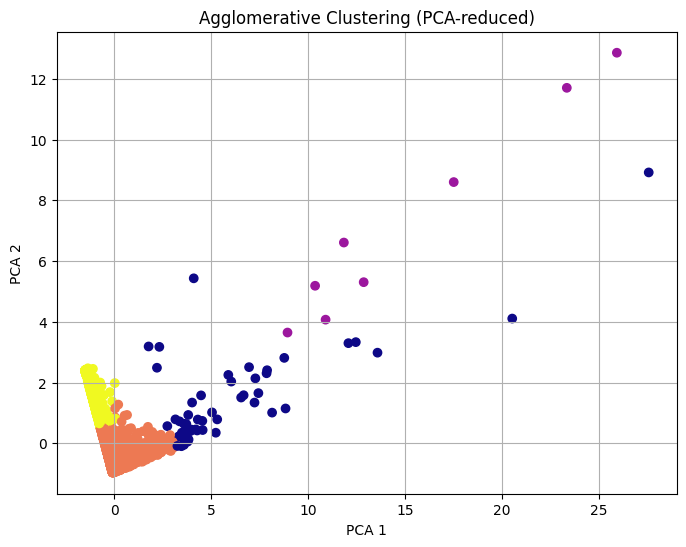

In [20]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4)
agg_labels = agg.fit_predict(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=agg_labels, cmap='plasma')
plt.title('Agglomerative Clustering (PCA-reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


###Silhouette Score to Compare

In [21]:
from sklearn.metrics import silhouette_score

print("KMeans Silhouette Score:", silhouette_score(rfm_scaled, kmeans.labels_))
print("DBSCAN Silhouette Score:", silhouette_score(rfm_scaled, db_labels))
print("Agglomerative Silhouette Score:", silhouette_score(rfm_scaled, agg_labels))


KMeans Silhouette Score: 0.616212846765192
DBSCAN Silhouette Score: 0.8634068574759618
Agglomerative Silhouette Score: 0.6065329601634818


###Comparision Chart
| Metric                     | KMeans                 | DBSCAN        | Agglomerative        |
| -------------------------- | ---------------------- | ------------- | -------------------- |
| **Silhouette Score**       | 0.6162                 | **0.8634**   | 0.6065               |
| **Handles Outliers?**      |  No                   |  Yes         |  No                 |
| **Assumes Cluster Shape**  |  Yes (spherical)      |  No          |  Yes (hierarchical) |
| **Scales with Data Size**  |  Fast                 |  Moderate   |  Slower             |
| **Number of Clusters?**    | Must be predefined (k) | Auto-detected | Must be predefined   |
| **Performance on Dataset** | Moderate               | **Best**     | Moderate             |


Create models/ directory

###Key Insights
Customer Segments Identified:

High-Value: Recent, frequent buyers who spend more.

Regular: Frequent but moderately recent purchasers.

Occasional: Moderate frequency, average spending.

At-Risk: Infrequent and outdated purchases.

Top Countries by Transactions: United Kingdom dominates with over 350k transactions, followed by Germany, France, and others.

Top-Selling Products:

"PAPER CRAFT , LITTLE BIRDIE" and

"MEDIUM CERAMIC TOP STORAGE JAR" lead in quantity sold.

Sales Trends: Notable fluctuations in daily revenue, indicating peak shopping days and seasonal trends.

Customer Revenue Distribution: A small group of customers contributes to a large share of revenue, a typical Pareto effect.



###Conclusion
The Shopper Spectrum application successfully integrates unsupervised learning and recommendation systems to:

Identify meaningful customer segments for targeted marketing.

Recommend similar products to improve cross-selling and user engagement.

This solution not only boosts customer experience but also empowers business teams with data-driven decisions for promotions and retention strategies.

In [ ]:
import os
os.makedirs("models", exist_ok=True)


Save Your Trained Objects

In [ ]:
import pickle

with open('kmeans_model_py310.pkl', 'wb') as f:
    pickle.dump(kmeans, f, protocol=4)  # Compatible with older versions


# Save StandardScaler
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save Similarity Matrix
with open("models/similarity_matrix.pkl", "wb") as f:
    pickle.dump(similarity_df, f)


In [ ]:
from google.colab import files
files.download("models/similarity_matrix.pkl")  # ✅ Correct



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download the Files from Colab to Your Local Machine

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/Shopper_Spectrum
!cp models/similarity_matrix.pkl /content/drive/MyDrive/Shopper_Spectrum/


In [ ]:
!ls /content/drive/MyDrive/Shopper_Spectrum/


similarity_matrix.pkl


In [ ]:
df.to_csv("ecommerce_data_cleaned.csv", index=False)
files.download("ecommerce_data_cleaned.csv")
